# Explorative data analysis of real world data on multiple sclerosis

This script extends the first script of that analysed the dataset. In this script here, I will train a model to address the following research questions:

- Based on the test results, can I classify subjects into diagnosed and control group?
- Which of the used methods is best suited for this classification problem?
- Which metric is most important to predict the participant group?
---

## 3) Preprocessing

Importing required libraries:

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from datetime import date
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
import math

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from treeinterpreter import treeinterpreter as ti

#from sklearn.metrics import confusion_matrix, roc_curve, 
sns.set_palette("RdBu_r", 7) # this sets the color palette
import warnings
from warnings import filterwarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')#, category=DataConversionWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None) # display all columns

**Preparing the data set**

First, we import the data from our data analysis script...

In [14]:
%store -r df # get dataframe from EDA script
df_model = df

no stored variable or alias #
no stored variable or alias get
no stored variable or alias dataframe
no stored variable or alias from
no stored variable or alias EDA
no stored variable or alias script


... and then drop unnecessary columns and those who contain timestamps.

In [15]:
df_model = df_model.drop(columns=['floodlightOpenId','participantCreatedOn','testCode','testMetricCode','participantIsControl','testStartedAt','testEndedAt','testResultMetricCreatedOn','Delta_test_register'])

With this, we are not able to include time-wise information into our model assume that all rows (respectively test results) are independent of each other - which isn't the case. However, for the scope of the project here, we will neglect participant specific developments.

Then, we define the feature set and the target variable:

In [16]:
X = df_model
y = df['participantIsControl']
y = y.reindex_like(X) # similar indexing as features
X.head()

,participantCountryOfResidence,participantSex,participantBirthYear,participantWeightLbs,participantHeightCms,testName,testMetricName,testResultMetricId,testResultMetricValue,Weekday_testResultCreatedOn,Holiday_testResultCreatedOn,Delta_Days_test_register,Delta_Weeks_test_register
0,US,male,1966,159.0,178.0,Daily Questions,Mood Response,115524,4.00,1,False,1,0
1,US,male,1966,159.0,178.0,Daily Questions,Mood Response,116040,5.00,3,False,3,0
4,US,male,1966,159.0,178.0,IPS,Correct Responses,116043,39.00,3,False,3,0
5,US,male,1966,159.0,178.0,IPS,Response Time Average,116044,2.31,3,False,3,0
6,US,male,1966,159.0,178.0,Pinching,Successful Pinches,116045,27.00,3,False,3,0


Now we need to encode some of the categorial features. Nominal feautures need to be transformed to dummy variables (by one-hot encoding). For ordinal categories, this depends on the variable itself. If we assume that the variable is close enough to be of interval type we can encode it as numerical data.

In [17]:
# create dummy variables of
dummy = pd.get_dummies(X['participantCountryOfResidence'],prefix='Country', columns = ['participantCountryOfResidence'], drop_first=True)
dummy2 = pd.get_dummies(X['participantSex'],prefix='Sex', columns = ['participantSex'], drop_first=True)
dummy3 = pd.get_dummies(X['testName'],prefix='testName', columns = ['testName'], drop_first=True)
dummy4 = pd.get_dummies(X['testMetricName'],prefix='testMetric', columns = ['testMetricName'], drop_first=True)
dummy5 = pd.get_dummies(X['Weekday_testResultCreatedOn'],prefix='Weekday', columns = ['Weekday_testResultCreatedOn'], drop_first=True)
dummy6 = pd.get_dummies(X['Holiday_testResultCreatedOn'],prefix='Holiday', columns = ['Holiday_testResultCreatedOn'], drop_first=True)
X = pd.concat([dummy,dummy2,dummy3,dummy4,dummy5,dummy6,X], axis=1);
X = X.drop(columns=['participantCountryOfResidence','participantSex','testResultMetricId','testName','testMetricName','Weekday_testResultCreatedOn','Holiday_testResultCreatedOn'], axis=1);
# reset indexes
X.reset_index(inplace=True)
X_index = X['index']
X = X.drop(columns=['index'], axis=1);
y.reset_index(drop=True,inplace = True)
y=y*1
X.head()

,Country_BE,Country_BR,Country_CA,Country_CH,Country_CZ,Country_DK,Country_ES,Country_FI,Country_IT,Country_PL,Country_US,Sex_male,testName_Draw A Shape,testName_Five UTurn Test,testName_IPS,testName_Mobility,testName_Pinching,testName_Static Balance,testName_Two Minute Walk Test,testMetric_Circle Hausdorff Distance Best,testMetric_Correct Responses,testMetric_Figure 8 Hausdorff Distance Best,testMetric_Hand Used,testMetric_Life Space Daily,testMetric_Mean Hausdorff Distance Best,testMetric_Mood Response,testMetric_Number of shapes drawn correctly,testMetric_Response Time Average,testMetric_Spiral Hausdorff Distance Best,testMetric_Square Hausdorff Distance Best,testMetric_Steps,testMetric_Successful Pinches,testMetric_Sway Path,testMetric_Top to bottom Hausdorff Distance Best,testMetric_Turn Speed Average,testMetric_Turns,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7,Holiday_True,participantBirthYear,participantWeightLbs,participantHeightCms,testResultMetricValue,Delta_Days_test_register,Delta_Weeks_test_register
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1966,159.0,178.0,4.00,1,0
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,5.00,3,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,39.00,3,0
3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,2.31,3,0
4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1966,159.0,178.0,27.00,3,0


Now, we split the dataset into the Training and Test set and rescale all of our features:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_rest.reset_index(drop=True,inplace = True)
#y_rest.reset_index(drop=True,inplace = True)

## 4) Modelling

In this section we will test different models our classification problem. Since this is an imbalanced data set, model accuracy is not an appropriate metric. Instead we will will evaluate the _'Area under curve (AUC)'_ of the _'ROC curve'_ (receiver operating characteristic curve) that can be used to evaluate the rate of True Positive and False Positive classifications. The higher the AUC value the better the classification. This metric is also more helpful to assess the models with respect to their performance for our classification problem.

### Logistic regression: 

In [19]:
classifier_LR = LogisticRegression(solver = 'saga')
classifier_LR.fit(X_train, y_train)
y_pred_LR = classifier_LR.predict(X_test)

In [20]:
# calculate average AUC:
fpra_LR, tpra_LR, _ = roc_curve(y_test, y_pred_LR)
auc_LR = auc(fpra_LR, tpra_LR)

# calculate R squared:
R2_LR_train = classifier_LR.score(X_train,y_train)
R2_LR_test = classifier_LR.score(X_test,y_test)

print('--- Logistic Regression ---')
print('AUC:      %1.3f' %auc_LR)
print('R2 Train: %1.3f' %R2_LR_train)
print('R2 Test:  %1.3f' %R2_LR_test)

--- Logistic Regression ---
AUC:      0.725
R2 Train: 0.850
R2 Test:  0.853


The ROC curve to evaluate the effectiveness of the approach. The true positive rate (sensitivity) is plotted over the false positive rate (100-specificity).

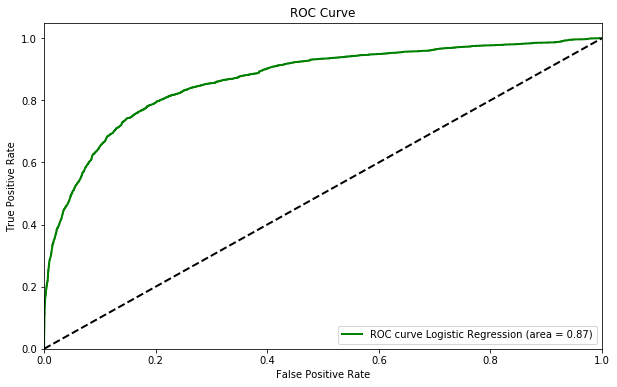

In [21]:
fpr_LR, tpr_LR, _ = roc_curve(y_test, classifier_LR.predict_proba(X_test)[:,1])
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.figure(figsize=(10,6))
plt.plot(fpr_LR, tpr_LR, color='green',
         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes

In [22]:
classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)
y_pred_NB = classifier_NB.predict(X_test)

In [23]:
# calculate average AUC:
fpra_NB, tpra_NB, _ = roc_curve(y_test, y_pred_NB)
auc_NB = auc(fpra_NB, tpra_NB)

# calculate R squared:
R2_NB_train = classifier_NB.score(X_train,y_train)
R2_NB_test = classifier_NB.score(X_test,y_test)

print('--- Naive Bayes ---')
print('AUC:      %1.3f' %auc_NB)
print('R2 Train: %1.3f' %R2_NB_train)
print('R2 Test:  %1.3f' %R2_NB_test)

--- Naive Bayes ---
AUC:      0.589
R2 Train: 0.815
R2 Test:  0.817


The ROC curve in comparison to the logistic regression:

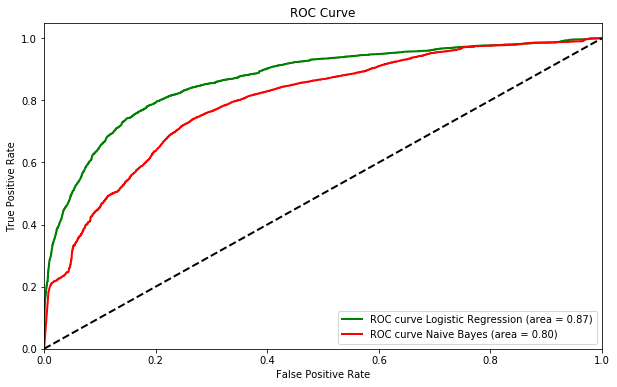

In [24]:
fpr_NB, tpr_NB, _ = roc_curve(y_test, classifier_NB.predict_proba(X_test)[:,1])
roc_auc_NB = auc(fpr_NB, tpr_NB)

plt.figure(figsize=(10,6))
plt.plot(fpr_LR, tpr_LR, color='green',
         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_NB, tpr_NB, color='red',
         lw=2, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_NB)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The metrics as well as the ROC plot shows that the logistic regression performed better in classifiying participants than the Naive Bayes approach.

### Random Forest:

In [25]:
classifier_RF = RandomForestClassifier(n_estimators = 25, max_depth = 10, criterion = 'entropy')
classifier_RF.fit(X_train, y_train)
y_pred_RF = classifier_RF.predict(X_test)

In [26]:
# calculate average AUC:
fpra_RF, tpra_RF, _ = roc_curve(y_test, y_pred_RF)
auc_RF = auc(fpra_RF, tpra_RF)

# calculate R squared:
R2_RF_train = classifier_RF.score(X_train,y_train)
R2_RF_test = classifier_RF.score(X_test,y_test)

print('--- Random Forest ---')
print('AUC:      %1.3f' %auc_RF)
print('R2 Train: %1.3f' %R2_RF_train)
print('R2 Test:  %1.3f' %R2_RF_test)

--- Random Forest ---
AUC:      0.830
R2 Train: 0.919
R2 Test:  0.920


The ROC curve:

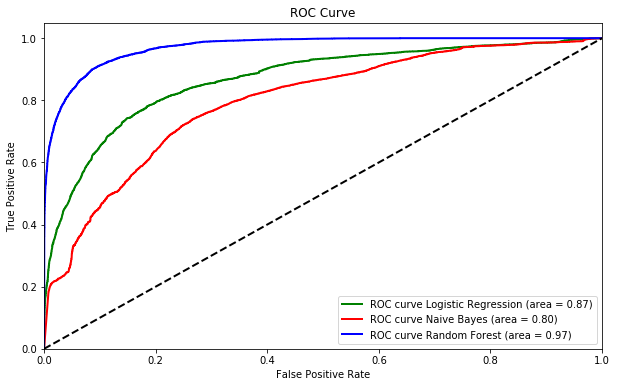

In [27]:
fpr_RF, tpr_RF, _ = roc_curve(y_test, classifier_RF.predict_proba(X_test)[:,1])
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.figure(figsize=(10,6))
plt.plot(fpr_LR, tpr_LR, color='green',
         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_NB, tpr_NB, color='red',
         lw=2, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_NB)
plt.plot(fpr_RF, tpr_RF, color='blue',
         lw=2, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The model did well to classify the participants. We can also see that the model didn't overfit (since R2 of the test set is pretty close to the R2 of the train set).  
Since the Random Forest is a tree-based approach, we do not get probabilities of the classifications. Subsequently, we can not plot the ROC curve for this model. However, the R2 seems pretty convincing.

---

## 5) Model comparison

Construct confusion matrices with relative distribution of all test set observations:

In [28]:
xlabels =['predicted control','predicted diagnosed']
ylabels =['control','diagnosed']
cm_LR = confusion_matrix(y_test, y_pred_LR)/len(y_pred_LR)
cm_NB = confusion_matrix(y_test, y_pred_NB)/len(y_pred_NB)
cm_RF = confusion_matrix(y_test, y_pred_RF)/len(y_pred_RF)
df_LR = pd.DataFrame(cm_LR, index=ylabels, columns=xlabels)
df_NB = pd.DataFrame(cm_NB, index=ylabels, columns=xlabels)
df_RF = pd.DataFrame(cm_RF, index=ylabels, columns=xlabels)

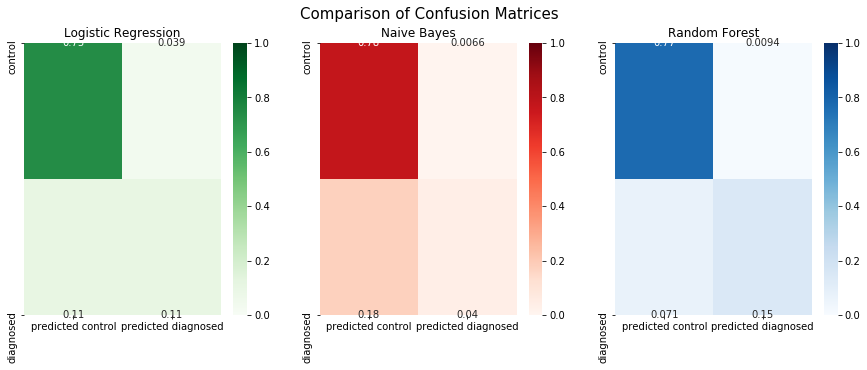

In [51]:
fig = plt.figure(figsize=(15,5))
fig.tight_layout()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.suptitle('Comparison of Confusion Matrices', fontsize = 15)
ax1.set_title("Logistic Regression")
ax2.set_title("Naive Bayes")
ax3.set_title("Random Forest")
sns.heatmap(df_LR, cmap='Greens', annot=True, ax=ax1, vmin=0, vmax=1)
sns.heatmap(df_NB, cmap='Reds', annot=True, ax=ax2, vmin=0, vmax=1)
sns.heatmap(df_RF, cmap='Blues', annot=True, ax=ax3, vmin=0, vmax=1)
#plt.tight_layout()
plt.show()

## 4) Cross-validation

Now, we check if the model results are affected by the way we split the training and test sets. The order of the observations could influence the classification, since e.g. the newest observations were sorted into the test set.
We use cross-validation on all applied models to check if the models can generalise and didn't overfit. To evaluate each individual prediction, we again use the ROC curve.

In [18]:
# using Stratified K-Folds cross-validator for train set
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=123)

**Logistic Regression**

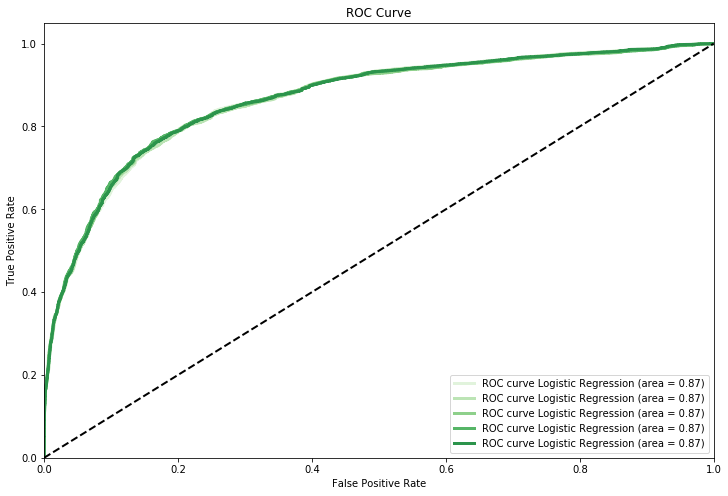

In [19]:
# Run classifier with cross-validation and plot individual ROC curves
sns.set_palette("Greens")
classifier_LR = LogisticRegression(solver = 'saga')

fig, ax = plt.subplots(figsize=(10,6))
for i, (train, test) in enumerate(cv.split(X, y)):
    sc = StandardScaler()
    X_train_cv = sc.fit_transform(X.loc[train])
    X_test_cv = sc.transform(X.loc[test])
    classifier_LR.fit(X_train_cv, y[train])
    fpr_cv, tpr_cv, _ = roc_curve(y[test], classifier_LR.predict_proba(X_test_cv)[:,1])    
    roc_auc_cv = auc(fpr_cv, tpr_cv)
    plt.plot(fpr_cv, tpr_cv, lw=3, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_cv)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Naive Bayes**

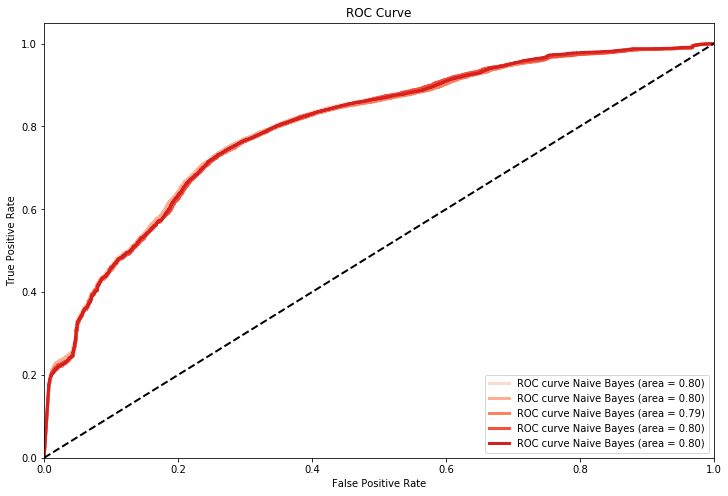

In [20]:
# Run classifier with cross-validation and plot individual ROC curves
sns.set_palette("Reds")
classifier_NB = GaussianNB()

fig, ax = plt.subplots(figsize=(10,6))
for i, (train, test) in enumerate(cv.split(X, y)):
    sc = StandardScaler()
    X_train_cv = sc.fit_transform(X.loc[train])
    X_test_cv = sc.transform(X.loc[test])
    classifier_NB.fit(X_train_cv, y[train])
    fpr_cv, tpr_cv, _ = roc_curve(y[test], classifier_NB.predict_proba(X_test_cv)[:,1])    
    roc_auc_cv = auc(fpr_cv, tpr_cv)
    plt.plot(fpr_cv, tpr_cv, lw=3, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_cv)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Random Forest**

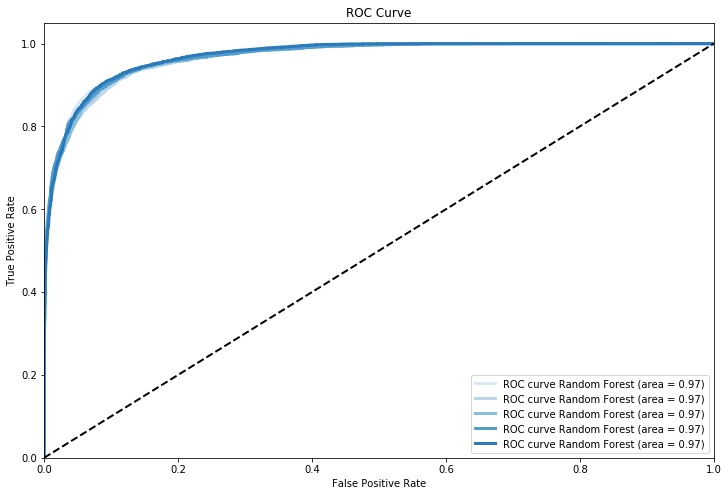

In [21]:
# Run classifier with cross-validation and plot individual ROC curves
sns.set_palette("Blues")
classifier_RF = RandomForestClassifier(n_estimators = 25, max_depth = 10, criterion = 'entropy')

fig, ax = plt.subplots(figsize=(10,6))
for i, (train, test) in enumerate(cv.split(X, y)):
    X_train_cv = X.loc[train]
    X_train_cv.reset_index(drop = True, inplace=True) # reset indexes
    y_train_cv = y[train]
    X_test_cv = X.loc[test]
    X_test_cv.reset_index(drop = True, inplace=True) # reset indexes
    y_test_cv = y[test]
    # feature scaling
    sc = StandardScaler()
    X_train_cv = sc.fit_transform(X_train_cv)
    X_test_cv = sc.transform(X_test_cv)
    
    classifier_RF.fit(X_train_cv, y_train_cv)
    fpr_cv, tpr_cv, _ = roc_curve(y_test_cv, classifier_RF.predict_proba(X_test_cv)[:,1])    
    roc_auc_cv = auc(fpr_cv, tpr_cv)
    plt.plot(fpr_cv, tpr_cv, lw=3, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_cv)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Since the cross-validation test confirmed our previous results, all models seem reliable over different splits of training and test sets. From all three models, the Random Forest performed best.

## 5) Test model hyperparameters

In order to check if we can further improve the performance of our Random Forest model, we will try out different combinations of hyperparameters to identify the ones which are most useful for our application.

**Grid search to check hyperparameters for best model (Random Forest)**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [23]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [10, 25], 'max_depth': [5, 10, 20], 'min_samples_split': [0.3, 0.6], 'min_samples_leaf': [0.2, 0.4], 'max_features': ['sqrt','log2',None]}]
scores = ['roc_auc']# 'recall']

In [25]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(criterion = 'entropy'), tuned_parameters, scoring='%s' % score
    )
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.2f %r" % (mean, params)) #(+/-%0.01f), std
    print()

    print("Best parameter set:")
    print()
    print(clf.best_params_)
    #print("The model is trained on the full development set.")
    #print("The scores are computed on the full evaluation set.")
    #print()
    #y_true, y_pred = y_test, clf.predict(X_test)
    #print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.3, 'n_estimators': 25}

Grid scores on development set:

0.718 (+/-0.088) for {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.3, 'n_estimators': 10}
0.775 (+/-0.025) for {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.3, 'n_estimators': 25}
0.754 (+/-0.036) for {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.6, 'n_estimators': 10}
0.757 (+/-0.039) for {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.6, 'n_estimators': 25}
0.500 (+/-0.000) for {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.4, 'min_samples_split': 0.3, 'n_estimators': 10}
0.500 (+/-0.000) for {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.4, 'min_samples_sp

We will update our model with the optimal hyperparameters:

In [26]:
print(clf.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.3, 'n_estimators': 25}


In [27]:
RandomForestClassifier(clf.best_params_, criterion = 'entropy')
classifier_RF.fit(X_train, y_train)
y_pred_RF = classifier_RF.predict(X_test)

In [28]:
# calculate average AUC:
fpra_RF, tpra_RF, _ = roc_curve(y_test, y_pred_RF)
auc_RF = auc(fpra_RF, tpra_RF)

# calculate R squared:
R2_RF_train = classifier_RF.score(X_train,y_train)
R2_RF_test = classifier_RF.score(X_test,y_test)

print('--- Random Forest ---')
print('AUC:      %1.3f' %auc_RF)
print('R2 Train: %1.3f' %R2_RF_train)
print('R2 Test:  %1.3f' %R2_RF_test)

--- Random Forest ---
AUC:      0.831
R2 Train: 0.921
R2 Test:  0.919


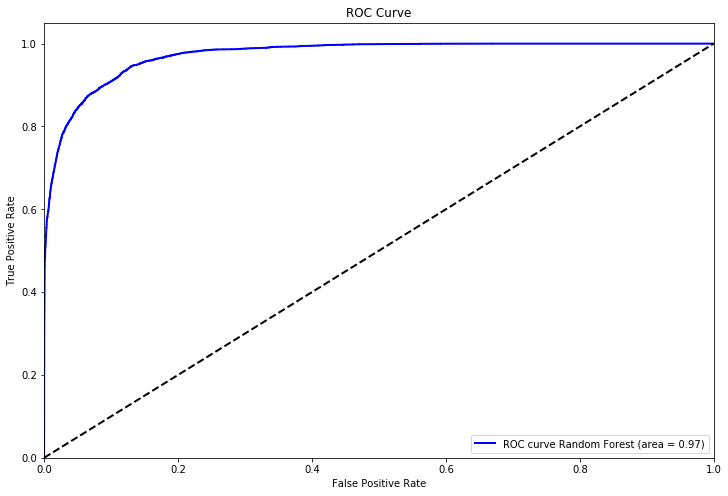

In [29]:
fpr_RF, tpr_RF, _ = roc_curve(y_test, classifier_RF.predict_proba(X_test)[:,1])
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.figure(figsize=(10,6))
plt.plot(fpr_RF, tpr_RF, color='blue',
         lw=2, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1, 'Confusion Matrix of Final Model')

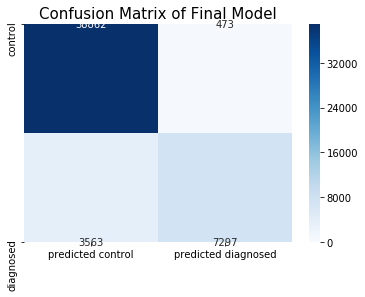

In [53]:
cm_RF = confusion_matrix(y_test, y_pred_RF)
df_RF = pd.DataFrame(cm_RF, index=ylabels, columns=xlabels)
fig = plt.figure()
fig.tight_layout()
sns.heatmap(df_RF, fmt="d", cmap='Blues', annot=True, vmin=0)
plt.title('Confusion Matrix of Final Model', fontsize = 15)

Still, we can see that more than 4000 entries were classified wrongly.

## 5) Model interpretation

**Feature importance**

Let's look at the importance of each feature and plot the 10 most important features:

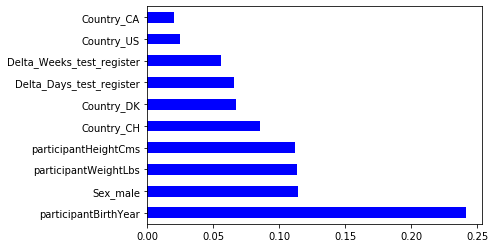

In [34]:
feat_importances = pd.Series(classifier_RF.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh',color='blue')
plt.show()

We can see that the most important features came from anthropomorphic data (like age, sex, height and weight) and the test results.

---
# Comments

* In this script we assumed that every test metric by itself is independent of the other metrics, which by default is wrong. Instead, the metrics of an individual should be merged into e.g. multiple global metric like mean, max, min, etc., all for each test day. Then, the analysis should be repeated. This will then result in classifications of participants instead of test metrics.
* The way how we encoded the categorial data, such like countries or the test metric names resulted in a data set with high cardinality (high number of features) but only spare information (due to the one-hot encoded features). This requires higher computational effort and results in worse performance of decision tree-based models. Binary Encoding could be a useful alternative to reduce the carinality in the data set. Other options are feature engineering, like merging countries into continents. The smaller number of features ('Europe', 'North America' and 'South America') would come, however, with a loss of information.

---
# Notes

### k-NN:

The k Nearest Neighbors approach requires timely computations to predict the test data set, which often is critical e.g. for online classification.  

In [8]:
classifier_kNN = KNeighborsClassifier(n_neighbors = 50, metric = 'minkowski', p = 2)
classifier_kNN.fit(X_train, y_train)
y_pred_kNN = classifier_kNN.predict(X_test)

# calculate average AUC:
fpra_kNN, tpra_kNN, _ = roc_curve(y_test, y_pred_kNN)
auc_kNN = auc(fpra_kNN, tpra_kNN)

# calculate R squared:
R2_kNN_train = classifier_kNN.score(X_train,y_train)
R2_kNN_test = classifier_kNN.score(X_test,y_test)

print('--- k Nearest Neighbors ---')
print('AUC:      %1.3f' %auc_kNN)
print('R2 Train: %1.3f' %R2_kNN_train)
print('R2 Test:  %1.3f' %R2_kNN_test)

--- k Nearest Neighbors ---
AUC:      0.769
R2 Train: 0.883
R2 Test:  0.879


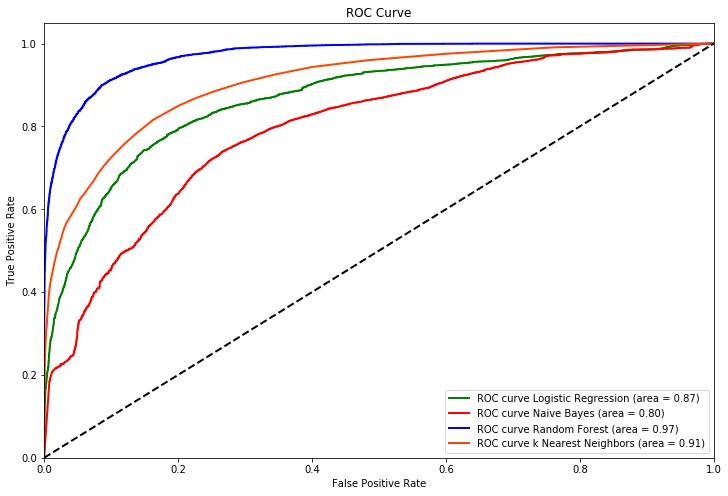

In [52]:
#fpr_kNN, tpr_kNN, _ = roc_curve(y_test, classifier_kNN.predict_proba(X_test)[:,1])
#roc_auc_kNN = auc(fpr_kNN, tpr_kNN)

plt.figure(figsize=(12,8))
plt.plot(fpr_LR, tpr_LR, color='green',
         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_NB, tpr_NB, color='red',
         lw=2, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_NB)
plt.plot(fpr_RF, tpr_RF, color='blue',
         lw=2, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_RF)
plt.plot(fpr_kNN, tpr_kNN, color='orangered',
         lw=2, label='ROC curve k Nearest Neighbors (area = %0.2f)' % roc_auc_kNN)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machines:

In this example, the support vector classifier requires exhaustive computations to train the model. I will therefore ignore this approach.

In [ ]:
# single SVM: 
#classifier_SVM = SVC(kernel = 'linear', class_weight ='balanced')
# Ensemble approach: 
n_estimators = 50
classifier_SVM = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), bootstrap=False, max_samples=1.0 / n_estimators, n_estimators=n_estimators))
classifier_SVM.fit(X_train, y_train)
y_pred_SVM = classifier_SVM.predict(X_test)

# calculate average AUC:
fpra_SVM, tpra_SVM, _ = roc_curve(y_test, y_pred_SVM)
auc_SVM = auc(fpra_SVM, tpra_SVM)

# calculate R squared:
R2_SVM_train = classifier_SVM.score(X_train,y_train)
R2_SVM_test = classifier_SVM.score(X_test,y_test)

print('--- k Nearest Neighbors ---')
print('AUC:      %1.3f' %auc_SVM)
print('R2 Train: %1.3f' %R2_SVM_train)
print('R2 Test:  %1.3f' %R2_SVM_test)


In [ ]:
fpr_SVM, tpr_SVM, _ = roc_curve(y_test, classifier_SVM.predict_proba(X_test)[:,1])
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

plt.figure(figsize=(12,8))
#plt.plot(fpr_LR, tpr_LR, color='green',
#         lw=2, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_LR)
#plt.plot(fpr_NB, tpr_NB, color='red',
#         lw=2, label='ROC curve Naive Bayes (area = %0.2f)' % roc_auc_NB)
plt.plot(fpr_SVM, tpr_SVM, color='blue',
         lw=2, label='ROC curve Support Vector Machine (area = %0.2f)' % roc_auc_SVM)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()